### Importing relevent libraries

In [1]:
import os
import PIL
import PIL.Image
from pathlib import Path
import tensorflow as tf
import pandas as pd
from livelossplot import PlotLossesKerasTF
import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)

2.8.3


Check if GPU is availabl.

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Loading data and creating datasets

In [4]:
os.chdir("..")

In [5]:
# Creating paths with data
DATA_DIR = Path('data')
DATA_DIR_TRAIN = DATA_DIR / 'train'
DATA_DIR_TEST = DATA_DIR / 'test_kaggle'

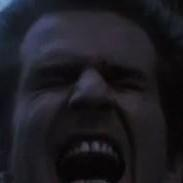

In [6]:
# Checking traim path
anger = list(DATA_DIR_TRAIN.glob('anger/*'))
PIL.Image.open(str(anger[0]))

In [8]:
# Folders with images are structured by classes, so we can use image_dataset_from_directory.
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

train_ds = tf.keras.utils.image_dataset_from_directory(DATA_DIR_TRAIN,
                                                       label_mode='categorical',
                                                       validation_split=0.2,
                                                       subset='training',
                                                       seed=0,
                                                       image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                       batch_size=BATCH_SIZE)

valid_ds = tf.keras.utils.image_dataset_from_directory(DATA_DIR_TRAIN,
                                                       label_mode='categorical',
                                                       validation_split=0.2,
                                                       subset='validation',
                                                       seed=0,
                                                       image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                       batch_size=BATCH_SIZE)

Found 50047 files belonging to 9 classes.
Using 40038 files for training.
Found 50047 files belonging to 9 classes.
Using 10009 files for validation.


In [9]:
# Checking classes
class_names = train_ds.class_names
print(class_names)

['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise', 'uncertain']


In [10]:
emotion_mapping = {k: v for v, k in enumerate(class_names)}
emotion_mapping

{'anger': 0,
 'contempt': 1,
 'disgust': 2,
 'fear': 3,
 'happy': 4,
 'neutral': 5,
 'sad': 6,
 'surprise': 7,
 'uncertain': 8}

In [11]:
# We will use ResNet50 pretrained model so we need to preprocess data
def preprocess(images, labels):
    return tf.keras.applications.resnet50.preprocess_input(images), labels

In [12]:
train_ds = train_ds.map(preprocess)
valid_ds = valid_ds.map(preprocess)

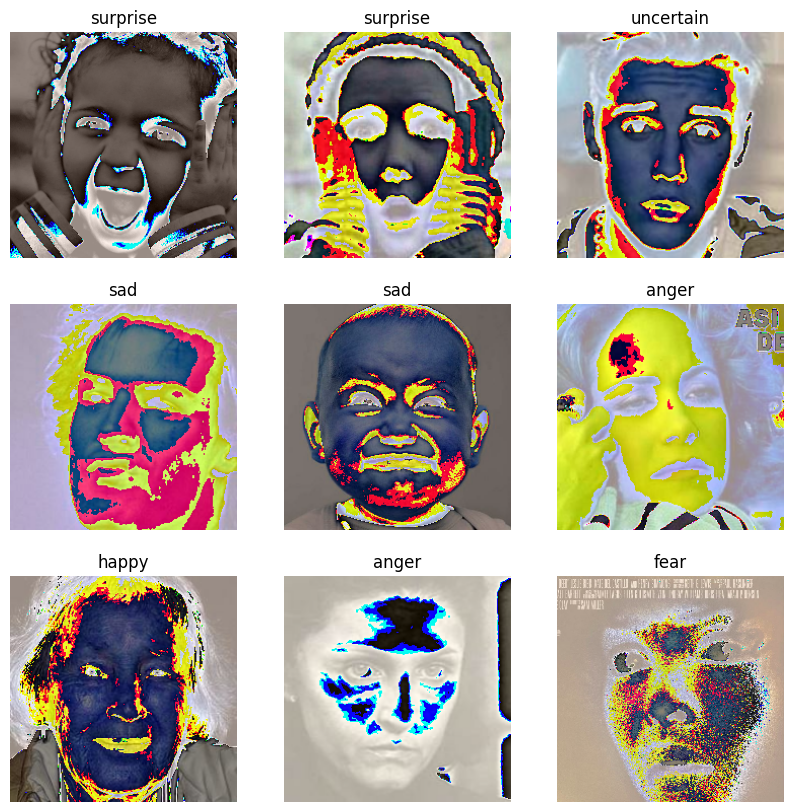

In [13]:
# Cheking preprocessed data
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[tf.math.argmax(labels, axis=1)[i]])
        plt.axis("off")

### Creating base model

In [14]:
# Base model with imagenet weights
base_model = tf.keras.applications.ResNet50(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights='imagenet')
base_model.trainable = False

In [15]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

### Creating simple models fot transfer learning and finetuning

<b>Without normalization</b>

In [16]:
x = tf.keras.layers.Flatten()(base_model.output)
output = tf.keras.layers.Dense(9, activation='softmax')(x)
model_01 = tf.keras.Model(inputs=[base_model.input], outputs=[output])

In [17]:
model_01.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

<b>Normalization</b>

In [18]:
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
normalization_layer = tf.keras.layers.Rescaling(1./255) # there is no scaling in ResNet50 preprocess input
x = normalization_layer(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(9, activation='softmax')(x)
model_01_norm = tf.keras.Model(inputs, outputs)

In [19]:
model_01_norm.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_1 (Dense)             (None, 9)                 903177    
                                                                 
Total params: 24,490,889
Trainable params: 903,177
Non-trainable params: 23,587,712
_________________________________________________________________


<b>Normalization + random data augumentation using Keras</b>

In [20]:
augmentation_layer = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                                         tf.keras.layers.RandomRotation(0.1)]) # some simple augumentation
normalization_layer = tf.keras.layers.Rescaling(1./255)    

inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = augmentation_layer(inputs)
x = normalization_layer(x)
x = base_model(x, training=False)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(9, activation='softmax')(x)
model_01_norm_aug = tf.keras.Model(inputs, outputs)

In [21]:
model_01_norm_aug.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 9)                 903177    
                                                                 
Total params: 24,490,889
Trainable params: 903,177
Non-trai

In [22]:
# Function for model compile
def model_compile(model, lr):
    model = model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                          loss='categorical_crossentropy',
                          metrics=['categorical_accuracy'])
    return model

In [23]:
LR = 1e-4
models_01 = [model_01, model_01_norm, model_01_norm_aug]

for model in models_01:
    model_compile(model, LR)

In [24]:
EPOCHS = 10

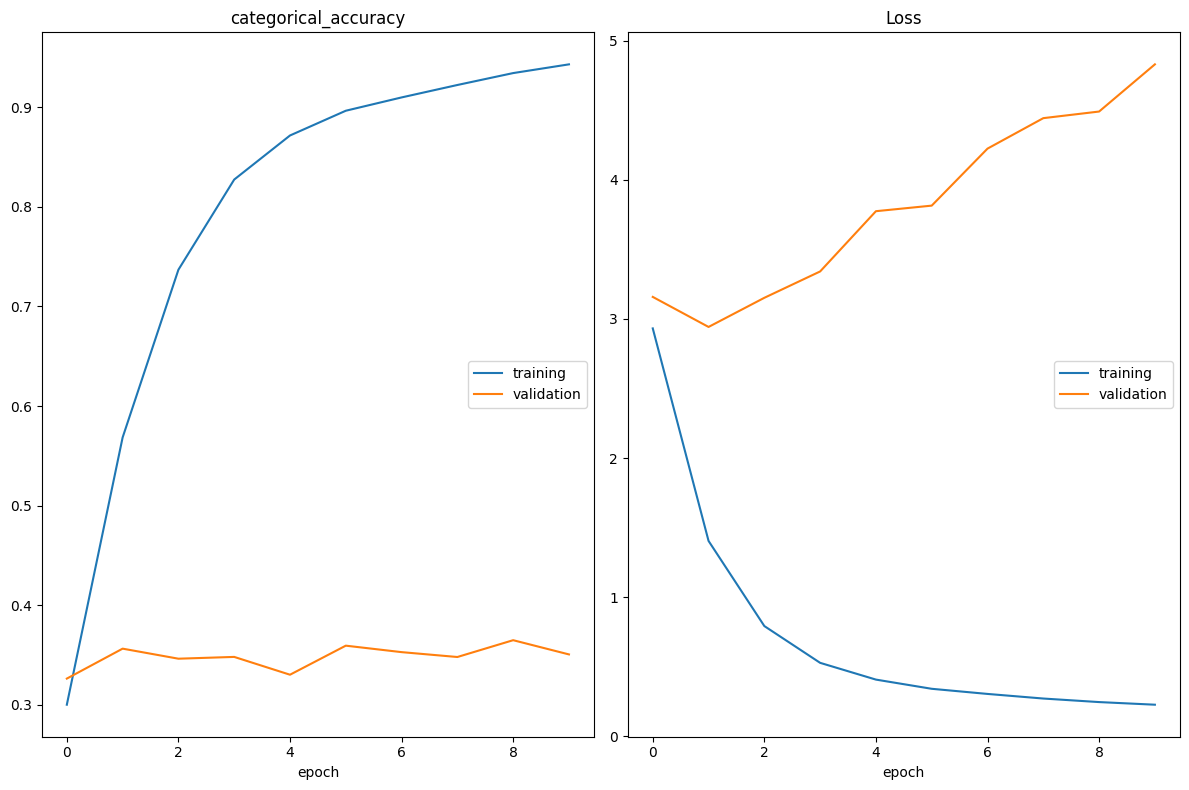

categorical_accuracy
	training         	 (min:    0.300, max:    0.943, cur:    0.943)
	validation       	 (min:    0.326, max:    0.365, cur:    0.351)
Loss
	training         	 (min:    0.228, max:    2.932, cur:    0.228)
	validation       	 (min:    2.943, max:    4.830, cur:    4.830)
1252/1252 [==============================] - 114s 91ms/step - loss: 0.2278 - categorical_accuracy: 0.9431 - val_loss: 4.8297 - val_categorical_accuracy: 0.3506


In [25]:
history_01 = model_01.fit(x=train_ds,
                          epochs=EPOCHS,
                          validation_data=valid_ds,
                          callbacks=[PlotLossesKerasTF()])

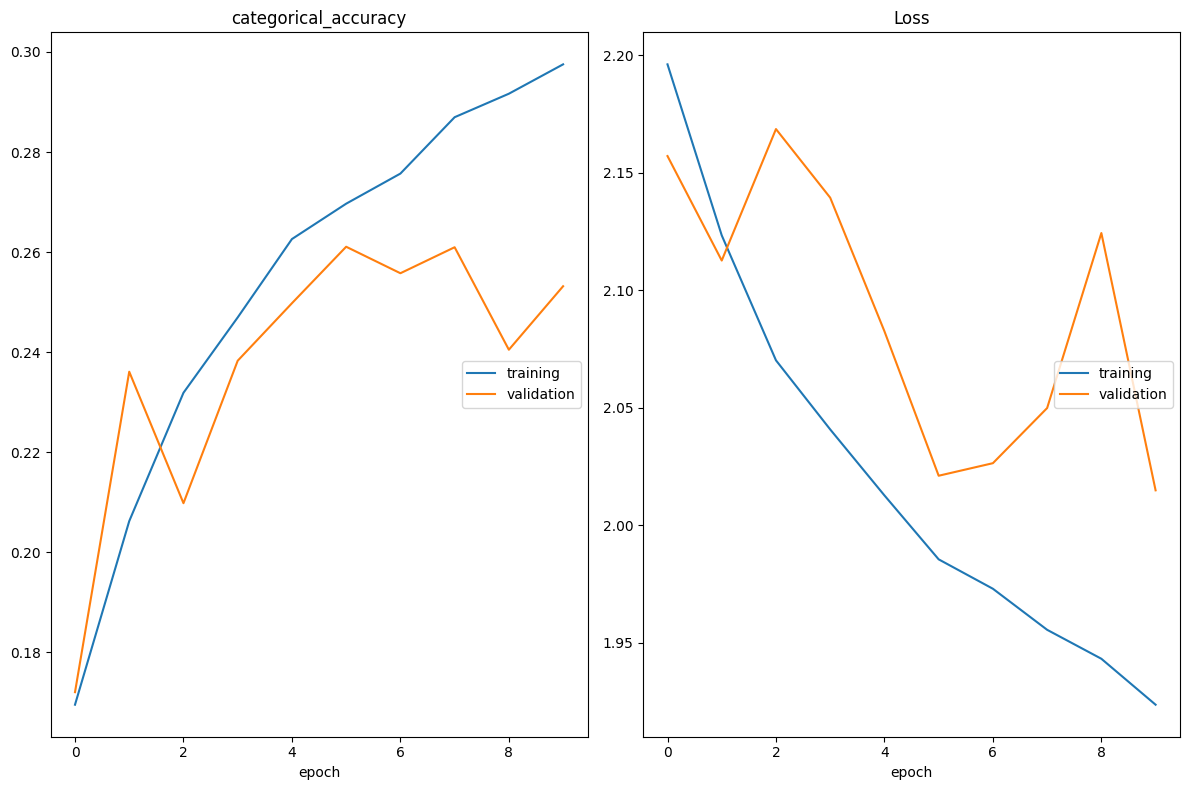

categorical_accuracy
	training         	 (min:    0.170, max:    0.298, cur:    0.298)
	validation       	 (min:    0.172, max:    0.261, cur:    0.253)
Loss
	training         	 (min:    1.924, max:    2.196, cur:    1.924)
	validation       	 (min:    2.015, max:    2.169, cur:    2.015)
1252/1252 [==============================] - 114s 90ms/step - loss: 1.9235 - categorical_accuracy: 0.2975 - val_loss: 2.0148 - val_categorical_accuracy: 0.2532


In [26]:
history_01_norm = model_01_norm.fit(x=train_ds,
                          epochs=EPOCHS,
                          validation_data=valid_ds,
                          callbacks=[PlotLossesKerasTF()])

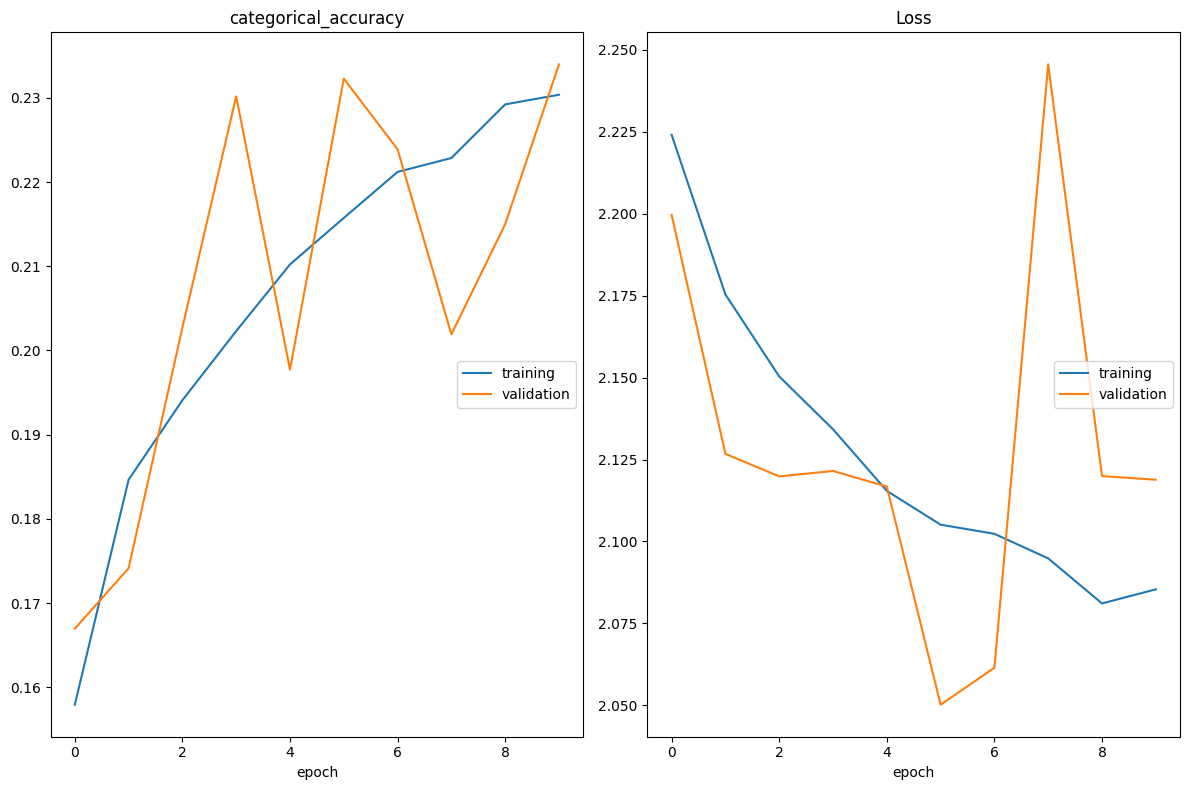

categorical_accuracy
	training         	 (min:    0.158, max:    0.230, cur:    0.230)
	validation       	 (min:    0.167, max:    0.234, cur:    0.234)
Loss
	training         	 (min:    2.081, max:    2.224, cur:    2.085)
	validation       	 (min:    2.050, max:    2.246, cur:    2.119)
1252/1252 [==============================] - 127s 101ms/step - loss: 2.0854 - categorical_accuracy: 0.2304 - val_loss: 2.1188 - val_categorical_accuracy: 0.2340


In [27]:
history_01_norm_aug = model_01_norm_aug.fit(x=train_ds,
                          epochs=EPOCHS,
                          validation_data=valid_ds,
                          callbacks=[PlotLossesKerasTF()])

<b>The first model is overfitted, so we won't try to tune it. </b>

### Tuning

##### Total layers of base resnet model

In [28]:
len(base_model.layers)

175

In [29]:
# Unfreeze some layers for tuning
base_model.trainable = True

NON_TRAINABLE_LAYERS = 140
for layer in base_model.layers[:NON_TRAINABLE_LAYERS]:
    layer.trainable = False

In [30]:
LR = 1e-5

for model in models_01:
    model_compile(model, LR)

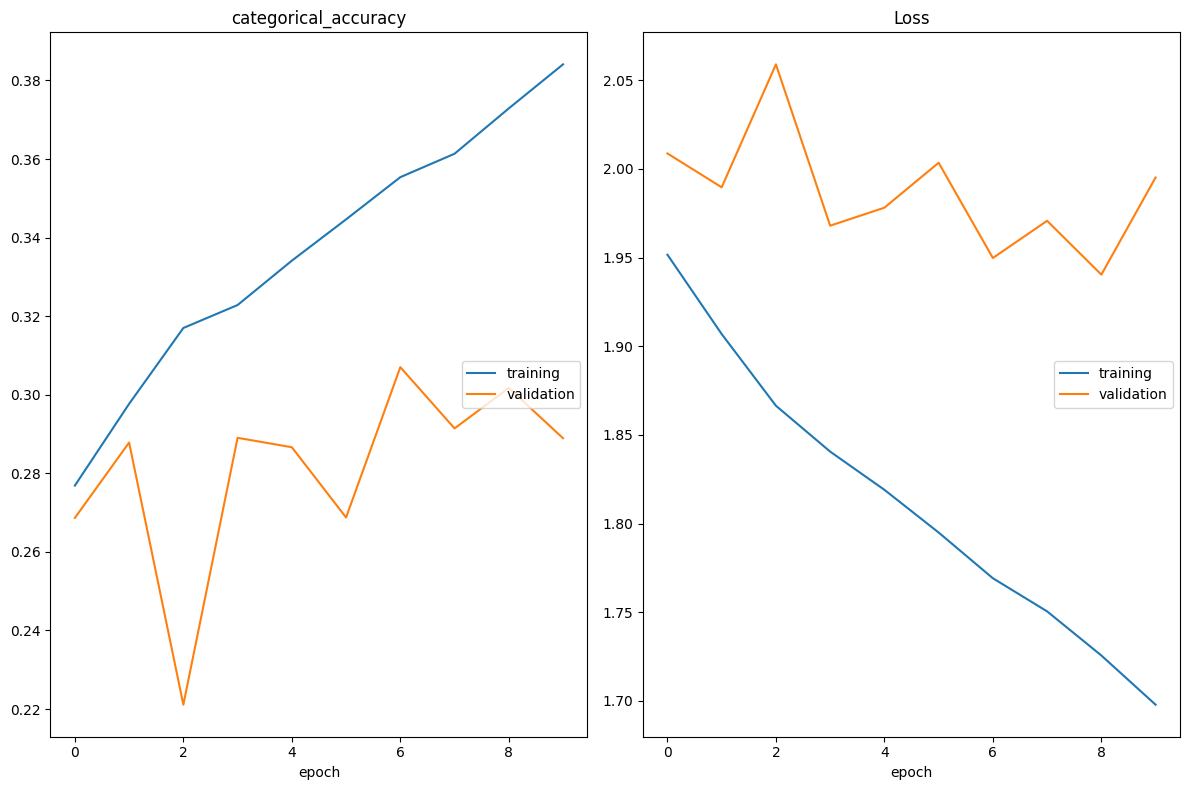

categorical_accuracy
	training         	 (min:    0.277, max:    0.384, cur:    0.384)
	validation       	 (min:    0.221, max:    0.307, cur:    0.289)
Loss
	training         	 (min:    1.698, max:    1.952, cur:    1.698)
	validation       	 (min:    1.940, max:    2.059, cur:    1.995)
1252/1252 [==============================] - 146s 116ms/step - loss: 1.6978 - categorical_accuracy: 0.3841 - val_loss: 1.9952 - val_categorical_accuracy: 0.2889


In [31]:
history_01_norm_tune = model_01_norm.fit(x=train_ds,
                          epochs=EPOCHS,
                          validation_data=valid_ds,
                          callbacks=[PlotLossesKerasTF()])

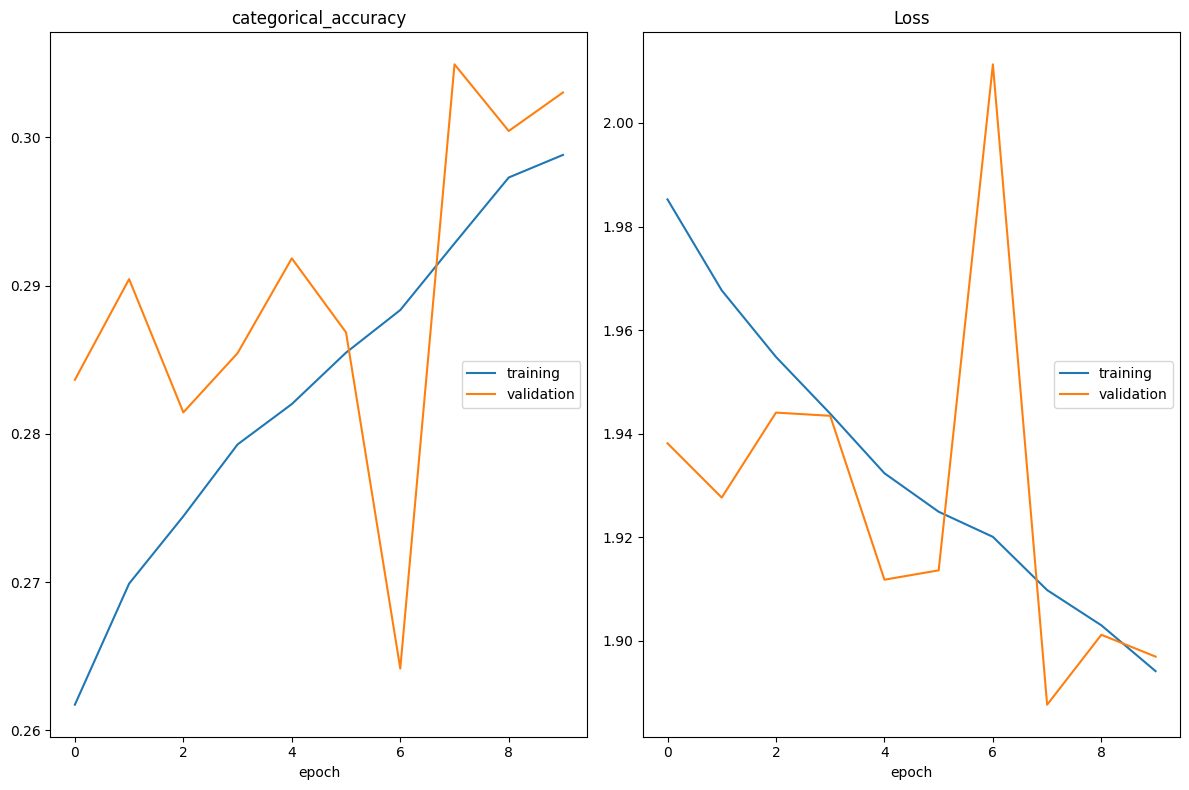

categorical_accuracy
	training         	 (min:    0.262, max:    0.299, cur:    0.299)
	validation       	 (min:    0.264, max:    0.305, cur:    0.303)
Loss
	training         	 (min:    1.894, max:    1.985, cur:    1.894)
	validation       	 (min:    1.888, max:    2.011, cur:    1.897)
1252/1252 [==============================] - 158s 126ms/step - loss: 1.8942 - categorical_accuracy: 0.2988 - val_loss: 1.8970 - val_categorical_accuracy: 0.3030


In [32]:
history_01_norm_aug_tune = model_01_norm_aug.fit(x=train_ds,
                          epochs=EPOCHS,
                          validation_data=valid_ds,
                          callbacks=[PlotLossesKerasTF()])

<b>The last model showed some accuracy without overfitting, we need to add layers to this model, maybe it will increase accuracy.</b>

### More complex model with more Dense layers + normalization + keras augumentatioт

In [42]:
# New similar base model
base_model = tf.keras.applications.ResNet50(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights='imagenet')
base_model.trainable = False

In [43]:
# New model with additional Dense layer
augmentation_layer = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                                         tf.keras.layers.RandomRotation(0.1)])
normalization_layer = tf.keras.layers.Rescaling(1./255)    

inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = augmentation_layer(inputs)
x = normalization_layer(x)
x = base_model(x, training=False)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
outputs = tf.keras.layers.Dense(9, activation='softmax')(x)
model_02_norm_aug = tf.keras.Model(inputs, outputs)

In [35]:
model_02_norm_aug.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 100352)            0         
                                                                 
 dense_3 (Dense)             (None, 512)               51380736  
                                                                 
 dense_4 (Dense)             (None, 9)                 4617

In [44]:
LR = 1e-4
EPOCHS = 20

model_compile(model_02_norm_aug, LR)

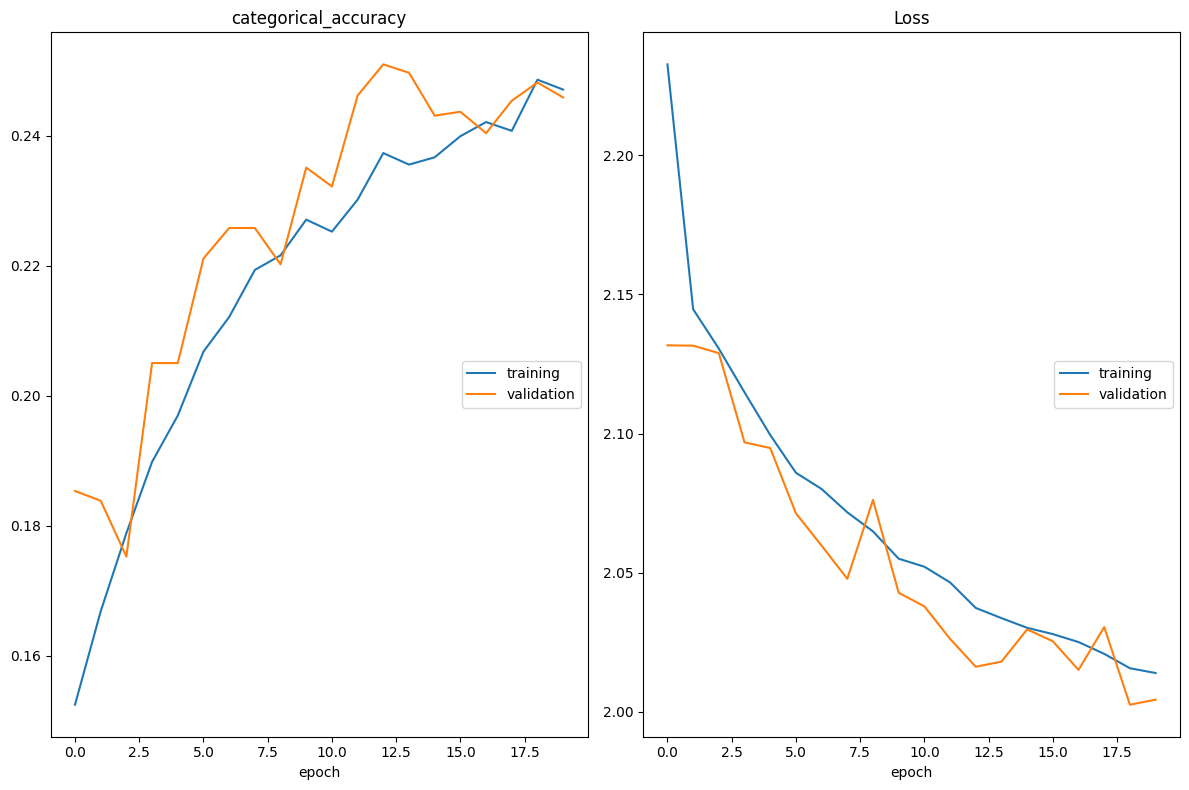

categorical_accuracy
	training         	 (min:    0.152, max:    0.249, cur:    0.247)
	validation       	 (min:    0.175, max:    0.251, cur:    0.246)
Loss
	training         	 (min:    2.014, max:    2.233, cur:    2.014)
	validation       	 (min:    2.003, max:    2.132, cur:    2.004)
1252/1252 [==============================] - 134s 107ms/step - loss: 2.0140 - categorical_accuracy: 0.2471 - val_loss: 2.0044 - val_categorical_accuracy: 0.2459


In [45]:
history_02_norm_aug = model_02_norm_aug.fit(x=train_ds,
                          epochs=EPOCHS,
                          validation_data=valid_ds,
                          callbacks=[PlotLossesKerasTF()])

<b>Categorical accuracy is better, but still not enough, the model needs tuning.</b>

In [46]:
base_model.trainable = True

NON_TRAINABLE_LAYERS = 140
for layer in base_model.layers[:NON_TRAINABLE_LAYERS]:
    layer.trainable = False

In [47]:
LR = 1e-5
EPOCHS = 60

model_compile(model_02_norm_aug, LR)

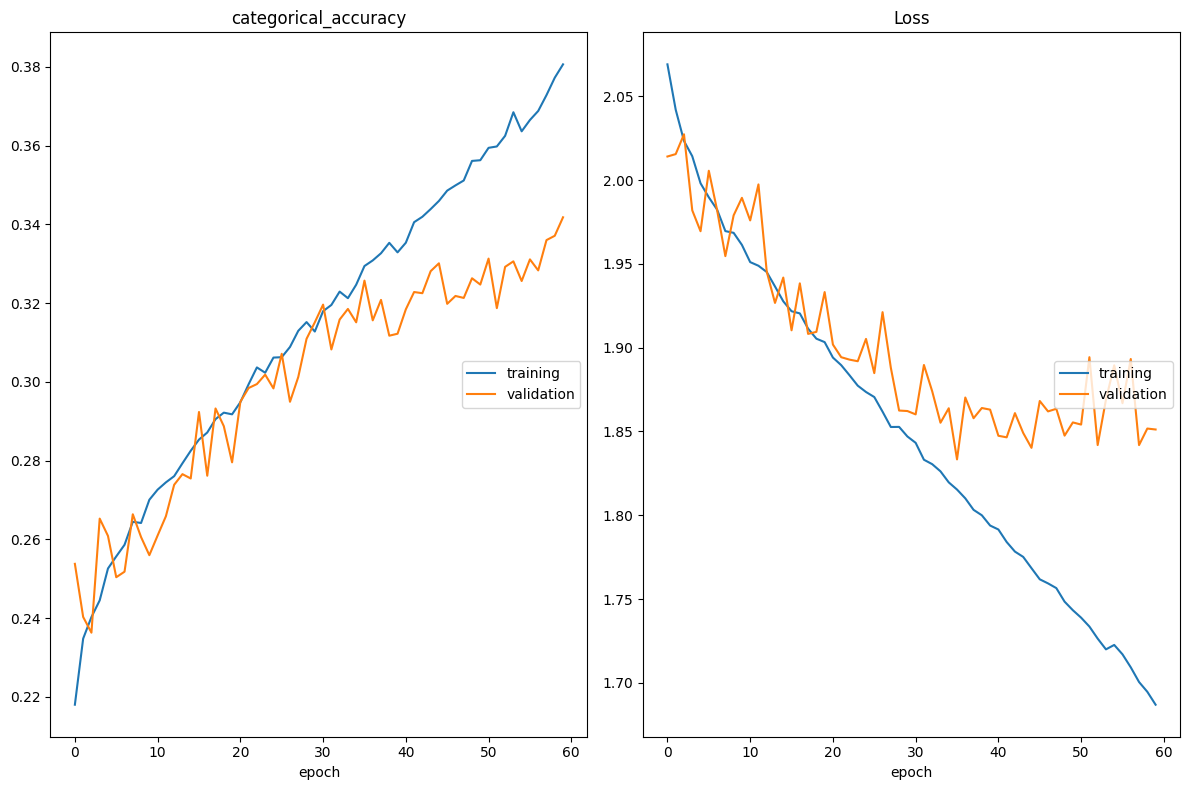

categorical_accuracy
	training         	 (min:    0.218, max:    0.381, cur:    0.381)
	validation       	 (min:    0.236, max:    0.342, cur:    0.342)
Loss
	training         	 (min:    1.687, max:    2.069, cur:    1.687)
	validation       	 (min:    1.833, max:    2.027, cur:    1.851)
1252/1252 [==============================] - 168s 134ms/step - loss: 1.6869 - categorical_accuracy: 0.3806 - val_loss: 1.8512 - val_categorical_accuracy: 0.3418


In [48]:
history_02_norm_aug = model_02_norm_aug.fit(x=train_ds,
                          epochs=EPOCHS,
                          validation_data=valid_ds,
                          callbacks=[PlotLossesKerasTF()])

<b>Accuracy increased again, but after ~40 epochs there is overfitting.</b>